In [1]:
cd /content/drive/MyDrive/HuggingFace_Pretrained_FineTuning/NewsDataSet

/content/drive/MyDrive/HuggingFace_Pretrained_FineTuning/NewsDataSet


Process Dataset

In [2]:
datapath = '/content/drive/MyDrive/HuggingFace_Pretrained_FineTuning/NewsDataSet/news.csv'
processedDataFolder = '/content/drive/MyDrive/HuggingFace_Pretrained_FineTuning/NewsDataSet'

In [3]:
test_data_ratio = 0.10
valid_data_ratio = 0.80

first_n_words = 200

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [5]:
def trim_string(x):

    x = x.split(maxsplit=first_n_words)
    x = ' '.join(x[:first_n_words])

    return x

In [8]:
# Read raw data
df_raw = pd.read_csv(datapath)

# Prepare columns
df_raw['label'] = (df_raw['label'] == 'FAKE').astype('int')
df_raw['titletext'] = df_raw['title'] + ". " + df_raw['text']
df_raw = df_raw.reindex(columns=['label', 'title', 'text', 'titletext'])

# Drop rows with empty text
df_raw.drop( df_raw[df_raw.text.str.len() < 5].index, inplace=True)

# Trim text and titletext to first_n_words
df_raw['text'] = df_raw['text'].apply(trim_string)
df_raw['titletext'] = df_raw['titletext'].apply(trim_string) 

# Split according to label
df_real = df_raw[df_raw['label'] == 0]
df_fake = df_raw[df_raw['label'] == 1]

# Train-test split
df_real_full_train, df_real_test = train_test_split(df_real, train_size = test_data_ratio, random_state = 1)
df_fake_full_train, df_fake_test = train_test_split(df_fake, train_size = test_data_ratio, random_state = 1)

# Train-valid split
df_real_train, df_real_valid = train_test_split(df_real_full_train, train_size = valid_data_ratio, random_state = 1)
df_fake_train, df_fake_valid = train_test_split(df_fake_full_train, train_size = valid_data_ratio, random_state = 1)

# Concatenate splits of different labels
df_train = pd.concat([df_real_train, df_fake_train], ignore_index=True, sort=False)
df_valid = pd.concat([df_real_valid, df_fake_valid], ignore_index=True, sort=False)
df_test = pd.concat([df_real_test, df_fake_test], ignore_index=True, sort=False)

# Write preprocessed data
df_train.to_csv(processedDataFolder + '/train.csv', index=False)
df_valid.to_csv(processedDataFolder + '/valid.csv', index=False)
df_test.to_csv(processedDataFolder + '/test.csv', index=False)

Data description

In [14]:
import pandas as pd

In [15]:
df = pd.read_csv('/content/drive/MyDrive/HuggingFace_Pretrained_FineTuning/NewsDataSet/train.csv')
df.head()

,label,title,text,titletext
0,0,Obamacare's unlikely No. 1 city,"Killing Obama administration rules, dismantlin...",Obamacare's unlikely No. 1 city. Killing Obama...
1,0,New York restores order for 2016 front-runners,Hillary Clinton and Donald Trump scored resoun...,New York restores order for 2016 front-runners...
2,0,These political scientists may have just disco...,There's a lot of disgust in America with polit...,These political scientists may have just disco...
3,0,"Hillary supporters: We're excited, too, but al...",Trump and Sanders get all the attention for th...,"Hillary supporters: We're excited, too, but al..."
4,0,Hung jury in Jodi Arias sentencing phase remov...,The jury in the Jodi Arias case tasked with de...,Hung jury in Jodi Arias sentencing phase remov...


Model Finetuning

In [9]:
!pip install transformers

     |████████████████████████████████| 1.8MB 4.1MB/s 
     |████████████████████████████████| 890kB 14.8MB/s 
     |████████████████████████████████| 2.9MB 12.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=63f27f93378c9dba310455ca959c6bcf4344a5e1d6a1723e89a2ab054c32ad47
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import torch

from torchtext.data import Field, TabularDataset, BucketIterator, Iterator

import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification

import torch.optim as optim

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

In [11]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [12]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Model Parameters

In [13]:
MAX_SEQ_LEN = 128
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)

In [16]:
label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(use_vocab=False, tokenize=tokenizer.encode, lower=False, include_lengths=False, batch_first=True,
                   fix_length=MAX_SEQ_LEN, pad_token=PAD_INDEX, unk_token=UNK_INDEX)
fields = [('label', label_field), ('title', text_field), ('text', text_field), ('titletext', text_field)]

In [18]:
train, valid, test = TabularDataset.splits(path=processedDataFolder, train='train.csv', validation='valid.csv',
                                           test='test.csv', format='CSV', fields=fields, skip_header=True)

Token indices sequence length is longer than the specified maximum sequence length for this model (706 > 512). Running this sequence through the model will result in indexing errors


Iterators

In [19]:
train_iter = BucketIterator(train, batch_size=16, sort_key=lambda x: len(x.text), device=device, train=True, sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid, batch_size=16, sort_key=lambda x: len(x.text), device=device, train=True, sort=True, sort_within_batch=True)
test_iter = Iterator(test, batch_size=16, device=device, train=False, shuffle=False, sort=False)

Model definition

In [21]:
class BERT(nn.Module):

    def __init__(self):
        super(BERT, self).__init__()
        options_name = "bert-base-uncased"
        self.encoder = BertForSequenceClassification.from_pretrained(options_name)

    def forward(self, text, label):
        loss, textFeature = self.encoder(text, labels=label)[:2]
        return loss, textFeature

Training

In [22]:
#Save checkpoint
def save_checkpoint(save_path, model, valid_loss):
    if save_path == None:
        return
    state_dict = {'model_state_dict': model.state_dict(),
                  'valid_loss': valid_loss}
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')

#Load checkpoint
def load_checkpoint(load_path, model):
    if load_path==None:
        return
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    model.load_state_dict(state_dict['model_state_dict'])
    return state_dict['valid_loss']

#Save metrics of the model
def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):
    if save_path == None:
        return
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')

#Load metrics
def load_metrics(load_path):
    if load_path==None:
        return
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

In [25]:
# Training Function

def train(model,
          optimizer,
          criterion = nn.BCELoss(),
          train_loader = train_iter,
          valid_loader = valid_iter,
          num_epochs = 5,
          eval_every = len(train_iter) // 2,
          file_path = processedDataFolder,
          best_valid_loss = float("Inf")):
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        for (labels, title, text, titletext), _ in train_loader:
            labels = labels.type(torch.LongTensor)           
            labels = labels.to(device)
            titletext = titletext.type(torch.LongTensor)  
            titletext = titletext.to(device)
            output = model(titletext, labels)
            loss, _ = output

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    

                    # validation loop
                    for (labels, title, text, titletext), _ in valid_loader:
                        labels = labels.type(torch.LongTensor)           
                        labels = labels.to(device)
                        titletext = titletext.type(torch.LongTensor)  
                        titletext = titletext.to(device)
                        output = model(titletext, labels)
                        loss, _ = output
                        
                        valid_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/' + 'model.pt', model, best_valid_loss)
                    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    
    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')

In [26]:
model = BERT().to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-5)

train(model=model, optimizer=optimizer)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Epoch [1/5], Step [16/160], Train Loss: 0.6636, Valid Loss: 0.6977
Model saved to ==> /content/drive/MyDrive/HuggingFace_Pretrained_FineTuning/NewsDataSet/model.pt
Model saved to ==> /content/drive/MyDrive/HuggingFace_Pretrained_FineTuning/NewsDataSet/metrics.pt
Epoch [1/5], Step [32/160], Train Loss: 0.4437, Valid Loss: 0.3547
Model saved to ==> /content/drive/MyDrive/HuggingFace_Pretrained_FineTuning/NewsDataSet/model.pt
Model saved to ==> /content/drive/MyDrive/HuggingFace_Pretrained_FineTuning/NewsDataSet/metrics.pt
Epoch [2/5], Step [48/160], Train Loss: 0.3010, Valid Loss: 0.2911
Model saved to ==> /content/drive/MyDrive/HuggingFace_Pretrained_FineTuning/NewsDataSet/model.pt
Model saved to ==> /content/drive/MyDrive/HuggingFace_Pretrained_FineTuning/NewsDataSet/metrics.pt
Epoch [2/5], Step [64/160], Train Loss: 0.2114, Valid Loss: 0.3028
Epoch [3/5], Step [80/160], Train Loss: 0.1551, Valid Loss: 0.2964
Epoch [3/5], Step [96/160], Train Loss: 0.1292, Valid Loss: 0.2137
Model save

Model loaded from <== /content/drive/MyDrive/HuggingFace_Pretrained_FineTuning/NewsDataSet/metrics.pt


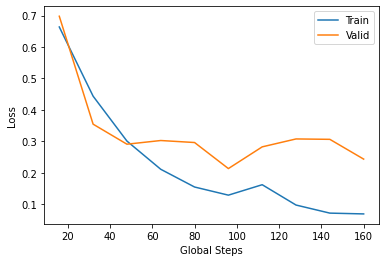

In [28]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics(processedDataFolder + '/metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

Evaluation

In [29]:
# Evaluation Function

def evaluate(model, test_loader):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (labels, title, text, titletext), _ in test_loader:

                labels = labels.type(torch.LongTensor)           
                labels = labels.to(device)
                titletext = titletext.type(torch.LongTensor)  
                titletext = titletext.to(device)
                output = model(titletext, labels)

                _, output = output
                y_pred.extend(torch.argmax(output, 1).tolist())
                y_true.extend(labels.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['FAKE', 'REAL'])
    ax.yaxis.set_ticklabels(['FAKE', 'REAL'])

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Model loaded from <== /content/drive/MyDrive/HuggingFace_Pretrained_FineTuning/NewsDataSet/model.pt
Classification Report:
              precision    recall  f1-score   support

           1     0.9454    0.8860    0.9148      2816
           0     0.8941    0.9495    0.9210      2854

    accuracy                         0.9180      5670
   macro avg     0.9198    0.9178    0.9179      5670
weighted avg     0.9196    0.9180    0.9179      5670



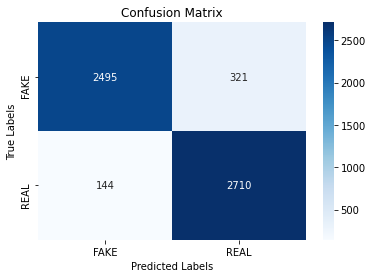

In [30]:
best_model = BERT().to(device)
load_checkpoint(processedDataFolder + '/model.pt', best_model)
evaluate(best_model, test_iter)